In [1]:
#IMPORTS
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
import json
from backtesting import Backtest, Strategy

import utils.labeling_algorithm as labeling_algorithm
import utils.la2 as la2
from utils.features_util import compute_features, get_available_features
from utils.cross_validation import custom_ten_fold_cv_selection, remove_monoton_instances, simple_ten_fold_cv_selection
import utils.sample_weights as sample_weights_util
import utils.xgb_utils as xgb_utils

In [2]:
#PARAMETERS
symbols = ['AMD', 'CLX']
start_date = '2019-11-30'
end_date = '2021-11-15'
#number of previous days to observe for next day's prediction
window = 30

close_prices = yf.download(symbols, start_date, end_date, progress=False)['Close']
market_series = yf.download('SPY', start_date, end_date, progress=False)['Close']

print(close_prices.shape)
print(close_prices.head(1))

(493, 2)
                             AMD         CLX
Date                                        
2019-12-02 00:00:00-05:00  38.73  148.929993


## 3-state labeling

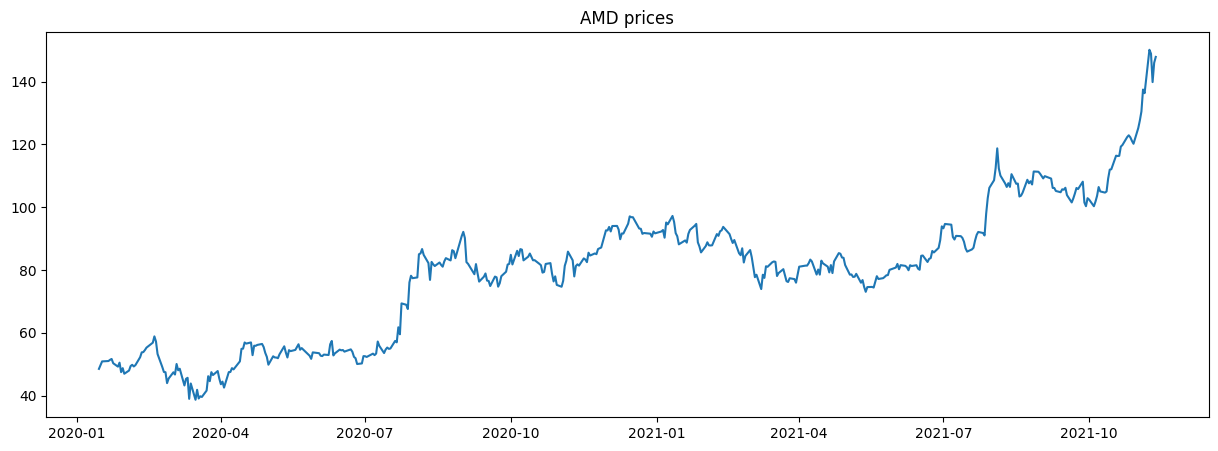

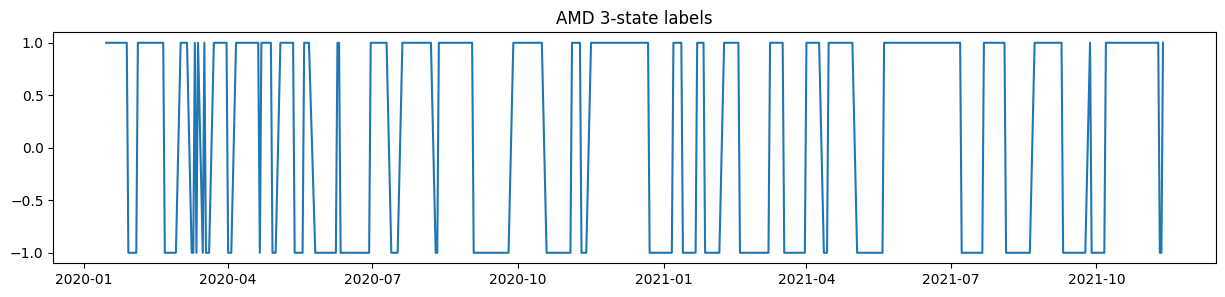

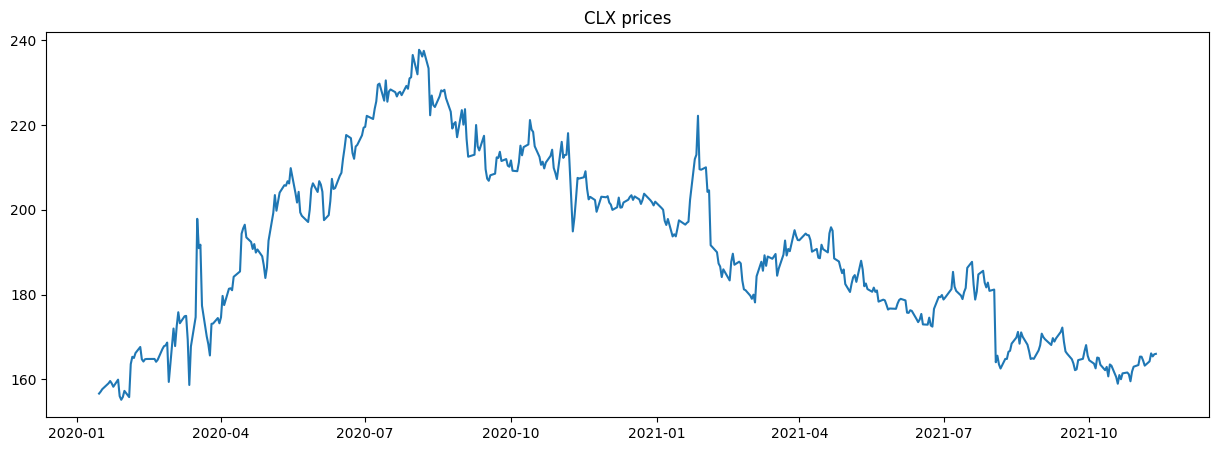

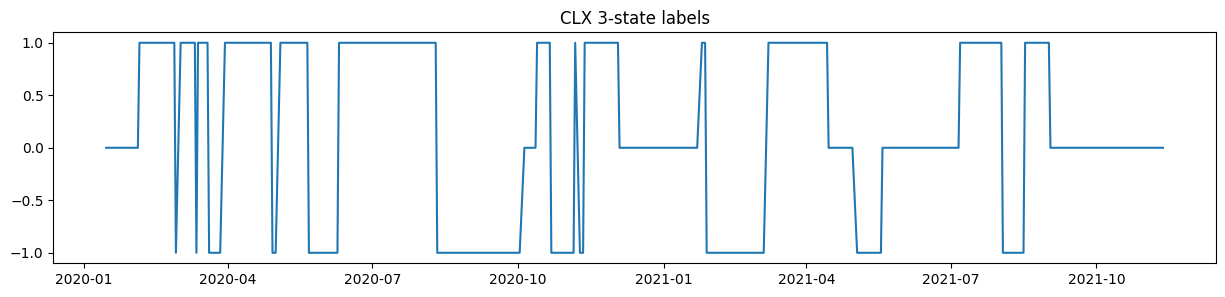

In [3]:
for stock in symbols:
    labels = labeling_algorithm.get_series_labels(close_prices[window:][stock], 0.05, 11)

    plt.figure(figsize=(15, 5), facecolor='w')
    plt.plot(close_prices[window:].index, close_prices[window:][stock])
    plt.title('{} prices'.format(stock))
    plt.show()
    plt.figure(figsize=(15, 3), facecolor='w')
    plt.plot(labels.index, labels)
    plt.title('{} 3-state labels'.format(stock))
    plt.show()

## 2-state labeling

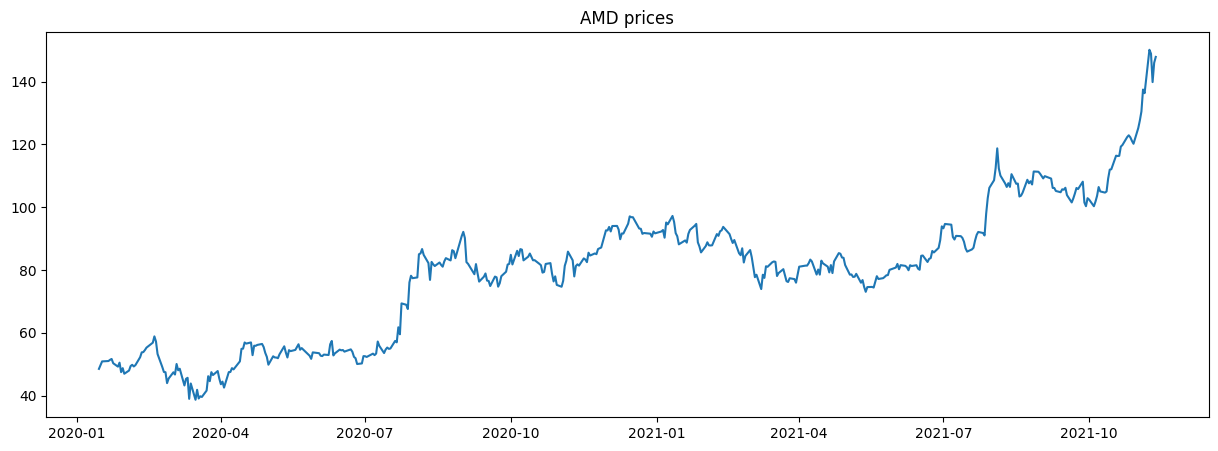

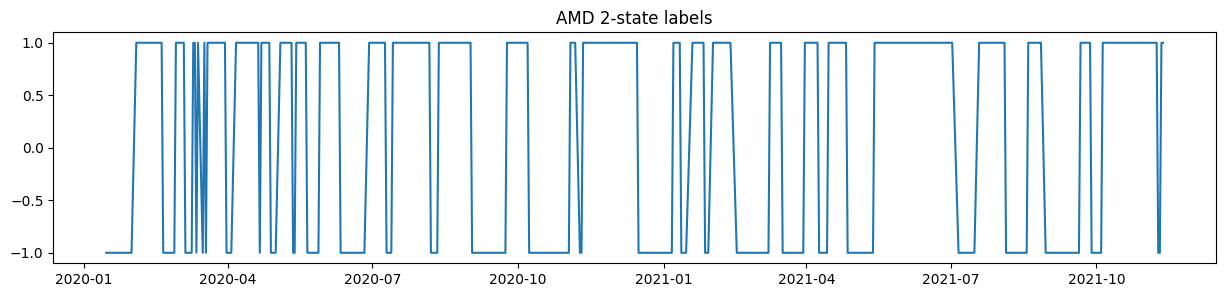

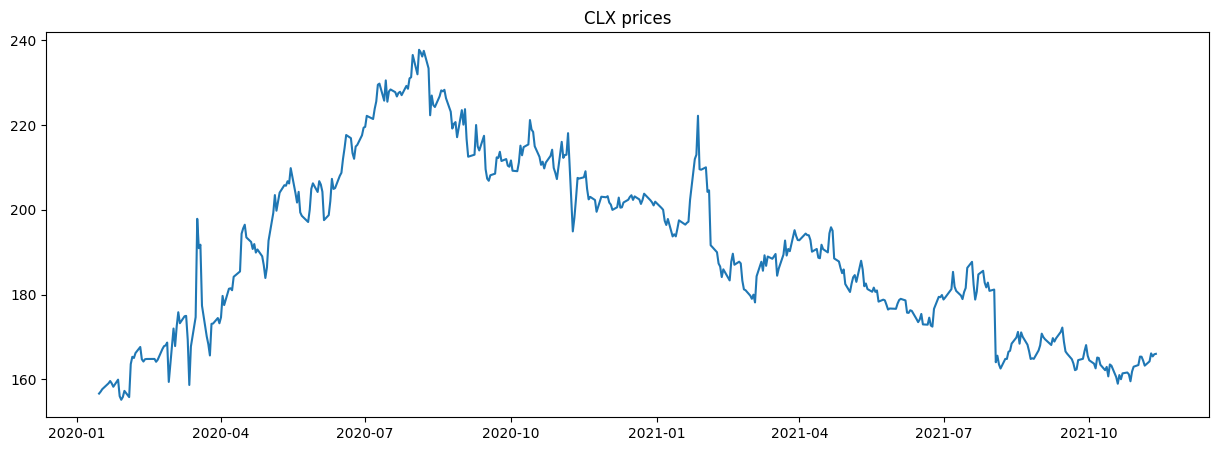

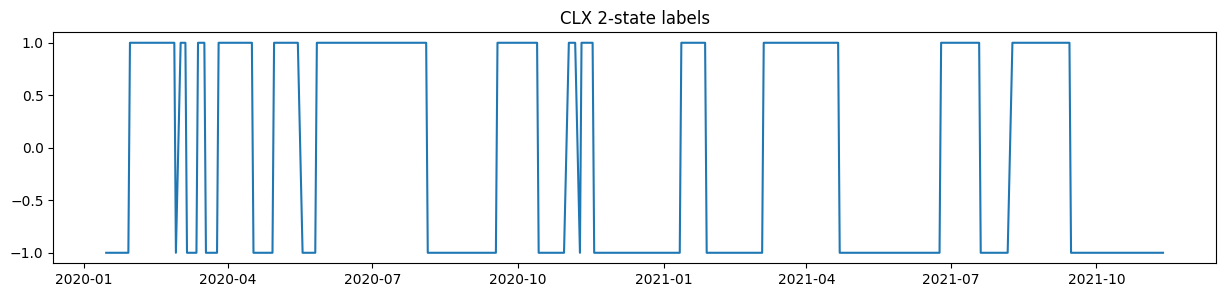

In [5]:
for stock in symbols:
    labels = la2.get_series_labels(close_prices[window:][stock], 0.05)

    plt.figure(figsize=(15, 5), facecolor='w')
    plt.plot(close_prices[window:].index, close_prices[window:][stock])
    plt.title('{} prices'.format(stock))
    plt.show()
    plt.figure(figsize=(15, 3), facecolor='w')
    plt.plot(labels.index, labels)
    plt.title('{} 2-state labels'.format(stock))
    plt.show()

## Features

In [7]:
features = get_available_features()
#create 2-lavel column dataframe, first level is stock symbol, second level is feature name
features_df = pd.DataFrame(columns = pd.MultiIndex.from_product([symbols, features]))

for stock in symbols:
    features_df[stock] = compute_features(stock, close_prices[stock], market_series, window)

print(features_df.head(2))

                                 AMD                                  \
                                 Min        Max       Mean       Std   
Date                                                                   
2020-01-15 00:00:00-05:00  38.730000  49.099998  44.167000  3.727913   
2020-01-16 00:00:00-05:00  38.900002  49.099998  44.494333  3.664640   

                                                                    \
                           Skewness  Kurtosis Chi-Square      Beta   
Date                                                                 
2020-01-15 00:00:00-05:00 -0.144715 -1.557263   2.918515  0.106646   
2020-01-16 00:00:00-05:00 -0.256371 -1.503638   2.953384  0.104903   

                                                CLX                          \
                            Mean_Volume         Min         Max        Mean   
Date                                                                          
2020-01-15 00:00:00-05:00  4.963797e+07  147.949997

## 10-fold corss validation

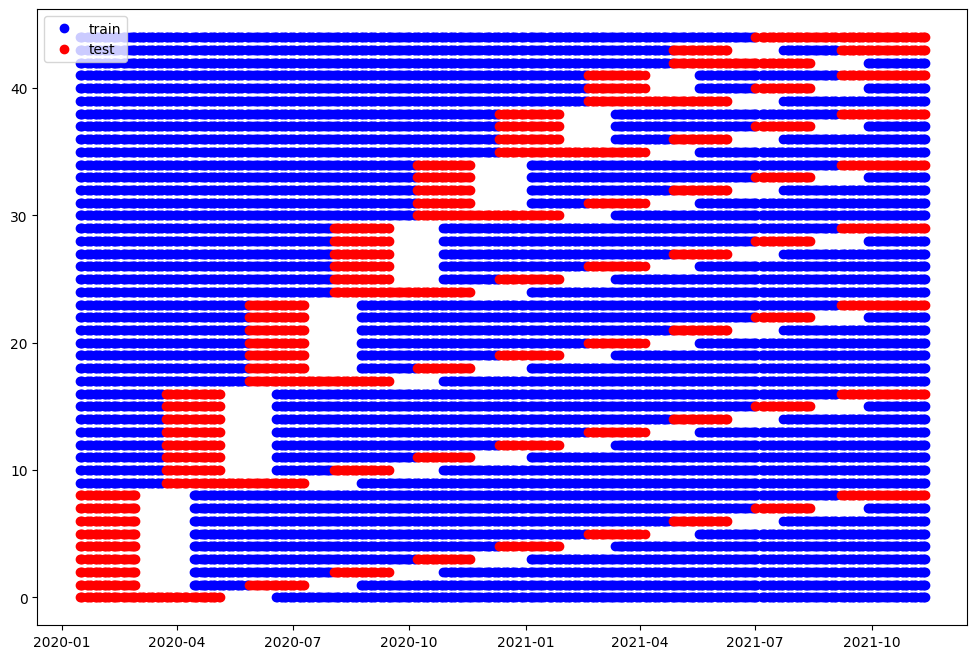

In [13]:
CVindices = simple_ten_fold_cv_selection(len(close_prices[window:]), window)

plt.figure(figsize=(12, 8), facecolor='w')
for i in range(0, len(CVindices)):
    trainIndices = CVindices[i][0]
    valIndices = CVindices[i][1]

    plt.plot(close_prices[window:].index[trainIndices], [i]*len(trainIndices), 'bo')
    plt.plot(close_prices[window:].index[valIndices], [i]*len(valIndices), 'ro')

plt.legend(['train', 'validation'])
plt.show()


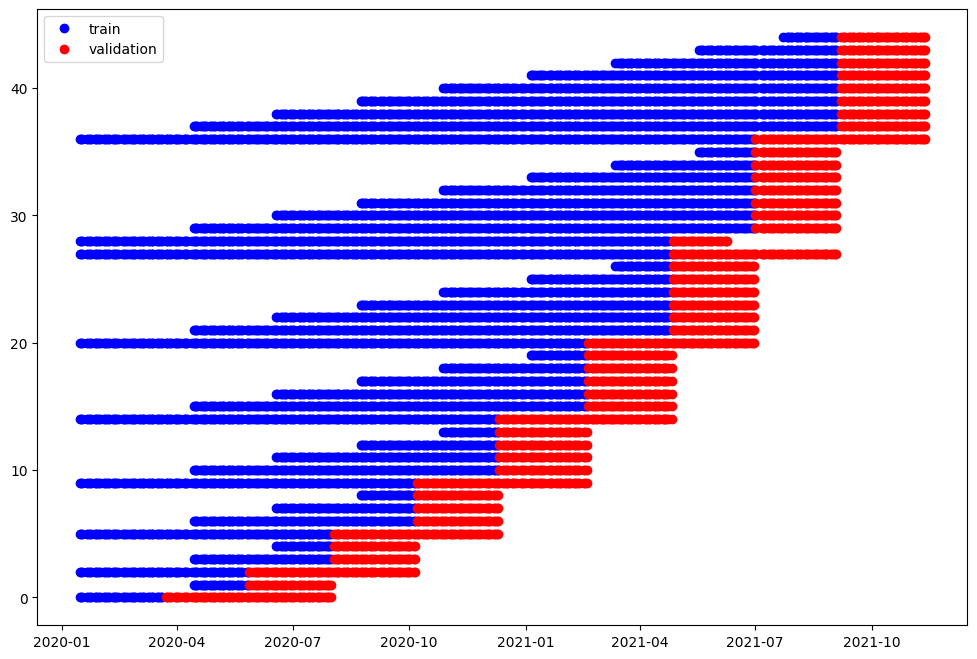

In [3]:
CVindices = custom_ten_fold_cv_selection(len(close_prices[window:]), window)

plt.figure(figsize=(12, 8), facecolor='w')
for i in range(0, len(CVindices)):
    trainIndices = CVindices[i][0]
    valIndices = CVindices[i][1]

    plt.plot(close_prices[window:].index[trainIndices], [i]*len(trainIndices), 'bo')
    plt.plot(close_prices[window:].index[valIndices], [i]*len(valIndices), 'ro')

plt.legend(['train', 'validation'])
plt.show()


## Sample weights
The greater the future profit/loss, the greater the sample weight.

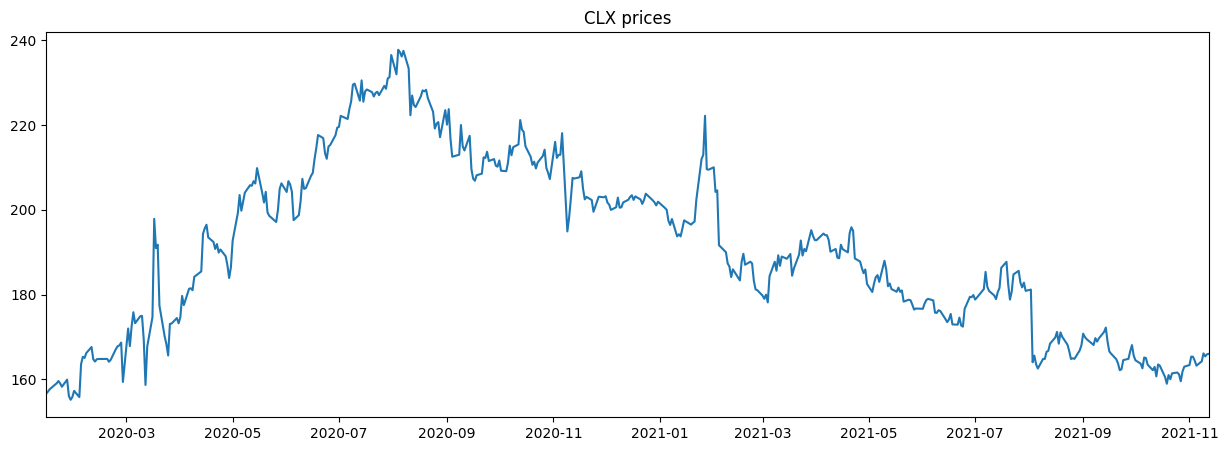

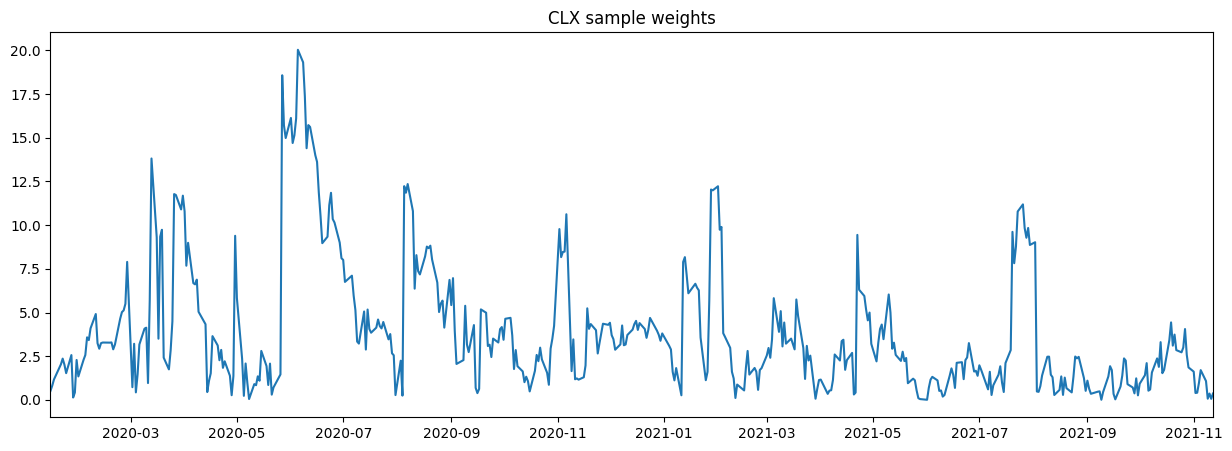

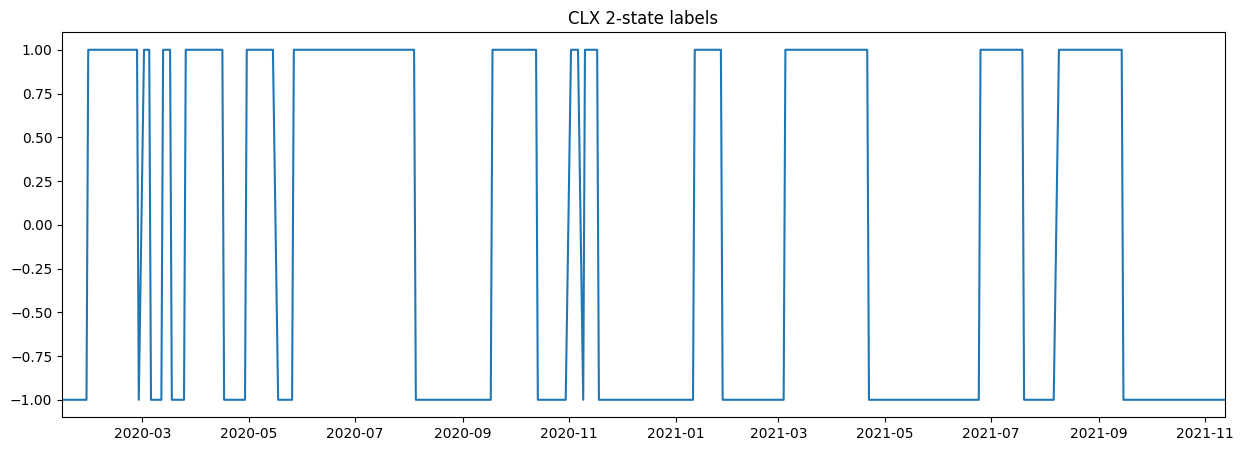

In [4]:
stock='CLX'
labels = la2.get_series_labels(close_prices[window:][stock], 0.05)
sample_weights = sample_weights_util.get(close_prices[window:][stock], labels)

plt.figure(figsize=(15, 5), facecolor='w')
plt.plot(close_prices[window:][stock].index, close_prices[window:][stock])
plt.title('{} prices'.format(stock))
plt.xlim(sample_weights.index[0], sample_weights.index[-1])
plt.show()

plt.figure(figsize=(15, 5), facecolor='w')
plt.plot(sample_weights.index, sample_weights)
plt.title('{} sample weights'.format(stock))
plt.xlim(sample_weights.index[0], sample_weights.index[-1])
plt.show()

plt.figure(figsize=(15, 5), facecolor='w')
plt.plot(labels.index, labels)
plt.title('{} 2-state labels'.format(stock))
plt.xlim(sample_weights.index[0], sample_weights.index[-1])
plt.show()

# XGBoost for CLX with 2-state labeling algorithm

In [3]:
stock = 'CLX'
window = 30

start_date_train = '2005-01-01'
end_date_train = '2015-12-31'
prices_train = yf.download(stock, start_date_train, end_date_train, progress=False)['Close']
market_prices_train = yf.download('SPY', start_date_train, end_date_train, progress=False)['Close']

start_date_test = '2016-01-01'
end_date_test = '2017-12-31'
prices_test = yf.download(stock, start_date_test, end_date_test, progress=False)['Close']
market_prices_test = yf.download('SPY', start_date_test, end_date_test, progress=False)['Close']

#FEATURES, 'X' of model
features_train = compute_features(stock, prices_train, market_prices_train, window)
features_test = compute_features(stock, prices_test, market_prices_test, window)

#LABELS, 'Y' of model
labels_train = la2.get_series_labels(prices_train[window:], 0.05)
labels_train[labels_train == -1] = 0
labels_test = la2.get_series_labels(prices_test[window:], 0.05)
labels_test[labels_test == -1] = 0

counts, values = np.unique(labels_train, return_counts=True)

#SAMPLE WEIGHTS
sw_train = sample_weights_util.get(prices_train[window:], labels_train)
sw_test = sample_weights_util.get(prices_test[window:], labels_test)

#CROSS VALIDATION INDICES
cv_inidces_list = custom_ten_fold_cv_selection(len(prices_train[window:]), window)
cv_inidces_list = remove_monoton_instances(cv_inidces_list, labels_train)

#SCALE POS WEIGHT
pos_weight = np.sum(labels_train == 0) / np.sum(labels_train == 1)

In [4]:
print('Simple model:')
xgb_utils.grid_search_cv_acc(features_train, labels_train, cv_inidces_list, saving_file='saved_models/{}_simple.json'.format(stock))
print('Class balancing model:')
xgb_utils.grid_search_cv_acc(features_train, labels_train, cv_inidces_list, scale_pos_weight=pos_weight, saving_file='saved_models/{}_class_balancing.json'.format(stock))
print('Sample weight model:')
xgb_utils.grid_search_cv_acc(features_train, labels_train, cv_inidces_list, sw_train=sw_train, saving_file='saved_models/{}_sample_weight.json'.format(stock))

Sample weight model:
Fitting 45 folds for each of 729 candidates, totalling 32805 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}
Best accuracy score: 53.71636797433881%


{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 1}

All models are optimized with GridSearchCV.
<br><br>
'simple' - model with basic parameters without class/sample weighting
<br>
'simple_sw' - 'simple' model tested on sample weighted test data
<br>
'class_balan' - model with class balancing
<br>
'class_balan_sw' - 'class_balan' model tested on sample weighted test data
<br>
'sample_weight' - model with sample weighting
<br>
'sample_weight_sw' - 'sample_weight' model tested on sample weighted test data

In [4]:
m_simple = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_simple.json'.format(stock))
m_simple_sw = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_simple.json'.format(stock), sw_test=sw_test)
m_class_balan = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_class_balancing.json'.format(stock))
m_class_balan_sw = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_class_balancing.json'.format(stock), sw_test=sw_test)
m_sample_weight = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_sample_weight.json'.format(stock), sw_train=sw_train)
m_sample_weight_sw = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_sample_weight.json'.format(stock), sw_train=sw_train, sw_test=sw_test)

m_df = pd.DataFrame(columns = ['Sample Weight Test', 'acc', 'f1', 'mse', 'auc'])
m_df.loc['simple'] = [False] + list(m_simple.values())
m_df.loc['simple_sw'] = [True] + list(m_simple_sw.values())
m_df.loc['class_balan'] = [False] + list(m_class_balan.values())
m_df.loc['class_balan_sw'] = [True] + list(m_class_balan_sw.values())
m_df.loc['sample_weight'] = [False] + list(m_sample_weight.values())
m_df.loc['sample_weight_sw'] = [True] + list(m_sample_weight_sw.values())

print("Models testing for 'CLX' stock.")
print(m_df)

Models testing for 'CLX' stock.
                 Sample Weight Test       acc        f1       mse       auc
simple                        False  0.503171  0.642314  0.496829  0.507340
simple_sw                      True  0.545153  0.694423  0.454847  0.503285
class_balan                   False  0.488372  0.626543  0.511628  0.492338
class_balan_sw                 True  0.547885  0.695726  0.452115  0.506292
sample_weight                 False  0.465116  0.634921  0.534884  0.470085
sample_weight_sw               True  0.534855  0.696945  0.465145  0.488448


### Backtesting

In [5]:
stock = 'CLX'
window = 30
refit_frequency = 5
train_data_size = 2500

In [13]:
start_date_train = '2005-01-01'
end_date_train = '2015-12-31'
prices_train = yf.download(stock, start_date_train, end_date_train, progress=False)['Close']
market_prices_train = yf.download('SPY', start_date_train, end_date_train, progress=False)['Close']
#FEATURES, 'X' of model
features_train = compute_features(stock, prices_train, market_prices_train, window)
#LABELS, 'Y' of model
labels_train = la2.get_series_labels(prices_train[window:], 0.05)
labels_train[labels_train == -1] = 0

with open('saved_models/{}_simple.json'.format(stock), 'r') as fp:
    model_params = json.load(fp)
xgb_model = xgb.XGBClassifier(**model_params)
xgb_model.fit(features_train, labels_train)
print()

In [14]:
predictions = []
class XGB2StateStrategy(Strategy):
    
    
    def init(self):
        self.window_size = window
        self.model = xgb_model
        self.feature_labels = get_available_features()
        self.refit_frequency = refit_frequency
        self.counter = 0
        self.train_data_size = train_data_size
        self.X_train = features_train
        self.Y_train = labels_train
    
    def next(self):
        self.counter += 1
        if self.counter == self.refit_frequency:
            self.X_train = self.X_train[-self.train_data_size:]
            self.Y_train = self.Y_train[-self.train_data_size:]
            self.model.fit(self.X_train, self.Y_train)
            self.counter = 0
        
        X_test = self.data.df[self.feature_labels].tail(1)
        prediction = self.model.predict(X_test)[0]
        
        self.X_train.append(X_test)
        self.Y_train = np.append(self.Y_train, self.data.df['Label'].tail(1))
        predictions.append(prediction)
        
        if prediction == 1:
            if self.position.is_short or not self.position:
                self.position.close()
                self.buy()
        else:
            if self.position.is_long or not self.position:
                self.position.close()
                self.sell()

In [8]:
start_date = '2016-01-01' #actual starting date is window_size working days after this date
end_date = '2023-01-01'
stock_prices_df = yf.download(stock, start_date, end_date, progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]
market_close_df = yf.download('SPY', start_date, end_date, progress=False)['Close']

features_df = compute_features(stock, stock_prices_df['Close'], market_close_df, window)

labels = la2.get_series_labels(stock_prices_df['Close'][window:], 0.05)
labels[labels == -1] = 0

data_df = pd.concat([stock_prices_df[window:], features_df], axis=1)
data_df['Label'] = labels

In [9]:
print(data_df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Min', 'Max', 'Mean', 'Std',
       'Skewness', 'Kurtosis', 'Chi-Square', 'Beta', 'Mean_Volume', 'Label'],
      dtype='object')


In [15]:
bt = Backtest(data_df, XGB2StateStrategy, cash=10_000)

# Run the backtest
stats = bt.run()
print(stats)

# Plot the results
bt.plot(filename='backtests/{}_simple.html'.format(stock))

# Print prediction accuracy
print('Model Accuracy =', accuracy_score(labels[:-1], predictions))

Start                     2016-02-17 00:00...
End                       2022-12-30 00:00...
Duration                   2508 days 00:00:00
Exposure Time [%]                   99.884527
Equity Final [$]                 17266.967018
Equity Peak [$]                  23238.471642
Return [%]                           72.66967
Buy & Hold Return [%]                8.429921
Return (Ann.) [%]                     8.27149
Volatility (Ann.) [%]               26.591339
Sharpe Ratio                          0.31106
Sortino Ratio                        0.476293
Calmar Ratio                         0.266017
Max. Drawdown [%]                  -31.093811
Avg. Drawdown [%]                   -4.673489
Max. Drawdown Duration      523 days 00:00:00
Avg. Drawdown Duration       45 days 00:00:00
# Trades                                  121
Win Rate [%]                        54.545455
Best Trade [%]                      32.784961
Worst Trade [%]                    -15.130082
Avg. Trade [%]                    